In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None, device='cuda'):
        self.data = pd.read_csv(csv_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.device = device
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['dx'])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id'] + '.jpg'
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                label = self.data.iloc[idx]['encoded_label']
                return image, label
        raise FileNotFoundError(f"Image {img_name} not found in directories {self.img_dirs}")


In [6]:
def plot_data_distribution_comparison(original_csv, synthetic_images_dir):
    """
    Compare the data distribution of the original HAM10000 dataset 
    with the distribution after adding synthetic images
    
    Args:
        original_csv (str): Path to the original metadata CSV file
        synthetic_images_dir (str): Path to the directory containing synthetic images
    """
    # Read the original metadata
    metadata = pd.read_csv(original_csv)
    
    # Count original class distribution
    original_class_counts = metadata['dx'].value_counts()
    
    # Prepare synthetic image class counts
    synthetic_class_counts = {}
    label_encoder = LabelEncoder()
    label_encoder.fit(metadata['dx'])
    
    # Count synthetic images per class
    for class_name in label_encoder.classes_:
        class_dir = os.path.join(synthetic_images_dir, class_name)
        if os.path.exists(class_dir):
            synthetic_class_counts[class_name] = len([f for f in os.listdir(class_dir) 
                                                      if f.endswith('.png')])
        else:
            synthetic_class_counts[class_name] = 0
    
    # Convert to Series for consistent plotting
    synthetic_class_counts = pd.Series(synthetic_class_counts)
    
    # Prepare the plot
    plt.figure(figsize=(15, 6))
    
    # Create a side-by-side bar plot
    x = np.arange(len(original_class_counts))
    width = 0.4
    
    plt.bar(x - width/2, original_class_counts.values, width, label='Original Dataset', color='blue', alpha=0.7)
    plt.bar(x + width/2, synthetic_class_counts.values, width, label='Synthetic Images', color='orange', alpha=0.7)
    
    plt.title('Comparison of Original HAM10000 Dataset and Synthetic Images', fontsize=16)
    plt.xlabel('Skin Lesion Type', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.xticks(x, original_class_counts.index, rotation=90, ha='right')
    plt.legend()
    
    # Add count labels on top of each bar
    for i, (orig, synth) in enumerate(zip(original_class_counts.values, synthetic_class_counts.values)):
        plt.text(i - width/2, orig + 50, str(int(orig)), ha='center', va='bottom', fontsize=8)
        plt.text(i + width/2, synth + 50, str(int(synth)), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('dataset_distribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show('dataset_distribution_comparison.png')
    plt.close()

    # Print detailed comparison
    print("\nOriginal Dataset Distribution:")
    total_original = len(metadata)
    for cls, count in original_class_counts.items():
        percentage = (count / total_original) * 100
        print(f"{cls}: {count} samples ({percentage:.2f}%)")
    
    print("\nSynthetic Images Distribution:")
    total_synthetic = synthetic_class_counts.sum()
    for cls, count in synthetic_class_counts.items():
        percentage = (count / total_synthetic) * 100 if total_synthetic > 0 else 0
        print(f"{cls}: {count} synthetic images ({percentage:.2f}%)")
    
    # Calculate and print augmentation ratio
    print("\nAugmentation Ratio:")
    for cls in original_class_counts.index:
        orig_count = original_class_counts.get(cls, 0)
        synth_count = synthetic_class_counts.get(cls, 0)
        augmentation_ratio = synth_count / orig_count if orig_count > 0 else 0
        print(f"{cls}: {augmentation_ratio:.2f}x")

Using device: cpu


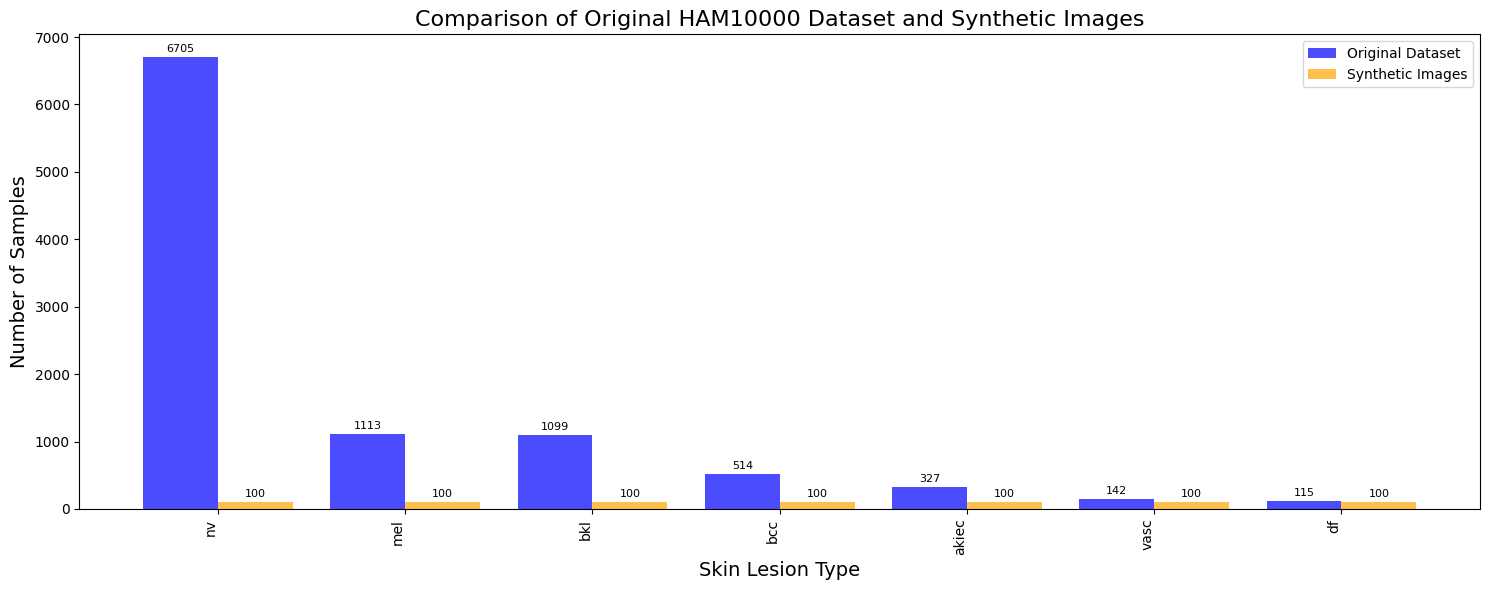


Original Dataset Distribution:
nv: 6705 samples (66.95%)
mel: 1113 samples (11.11%)
bkl: 1099 samples (10.97%)
bcc: 514 samples (5.13%)
akiec: 327 samples (3.27%)
vasc: 142 samples (1.42%)
df: 115 samples (1.15%)

Synthetic Images Distribution:
akiec: 100 synthetic images (14.29%)
bcc: 100 synthetic images (14.29%)
bkl: 100 synthetic images (14.29%)
df: 100 synthetic images (14.29%)
mel: 100 synthetic images (14.29%)
nv: 100 synthetic images (14.29%)
vasc: 100 synthetic images (14.29%)

Augmentation Ratio:
nv: 0.01x
mel: 0.09x
bkl: 0.09x
bcc: 0.19x
akiec: 0.31x
vasc: 0.70x
df: 0.87x
Unique Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Number of Classes: 7
Epoch [0/1], D_loss: 1.4191, G_loss: 0.6005


In [ ]:
class SLEBlock(nn.Module):
    def __init__(self, in_channels):
        super(SLEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // 2, 1)
        self.fc2 = nn.Conv2d(in_channels // 2, in_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        x = self.global_pool(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return y * x
        
class FASTGANGenerator(nn.Module):
    def __init__(self, latent_dim=256, ngf=64, output_size=64):
        super(FASTGANGenerator, self).__init__()
        self.output_size = output_size
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 16, 4, 1, 0),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True)
        )
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
        )
        self.sle1 = SLEBlock(ngf * 8)
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.sle2 = SLEBlock(ngf * 4)
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.initial(z)
        x = self.layer1(x)
        x = self.sle1(x, x)
        x = self.layer2(x)
        x = self.sle2(x, x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

class FASTGANDiscriminator(nn.Module):
    def __init__(self, ndf=64, input_size=64):
        super(FASTGANDiscriminator, self).__init__()
        self.input_size = input_size
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ndf * 8, 1, 1),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class SelfSupervisedDiscriminator(nn.Module):
    def __init__(self, ndf=64):
        super(SelfSupervisedDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1),          # 16x16 -> 8x8
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),   # 8x8 -> 4x4
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),  # 4x4 -> 2x2
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),  # 2x2 -> 1x1
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 8, ndf * 16, 1, 1, 0), # 1x1 -> 1x1
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 16, 1, 1, 1, 0),      # 1x1 -> 1x1
            nn.Sigmoid()
        )
        
        # Small decoders for self-supervised learning
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(ndf * 16, ndf * 8, 4, 1, 0),   # 1x1 -> 2x2
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ndf * 8, ndf * 4, 4, 2, 1),    # 2x2 -> 4x4
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ndf * 4, ndf * 2, 4, 2, 1),    # 4x4 -> 8x8
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ndf * 2, 3, 4, 2, 1),          # 8x8 -> 16x16
            nn.Tanh()
        )

    def forward(self, x):
        features = self.main[:-1](x)            # Extract features before the final layer
        validity = self.main[-1](features)      # Compute validity score
        reconstruction = self.decoder1(features) # Reconstruct the image
        
        # Debugging Statements
        print(f"Input Image Size: {x.size()}")
        print(f"Reconstructed Image Size: {reconstruction.size()}")
        
        return validity, reconstruction

def train_step(real_imgs, generator, discriminator, g_optimizer, d_optimizer, 
               device, autoencoder_loss):
    batch_size = real_imgs.size(0)
    
    # Train Discriminator
    d_optimizer.zero_grad()
    
    real_validity = discriminator(real_imgs)
    
    z = torch.randn(batch_size, 256, 1, 1, device=device)
    fake_imgs = generator(z)
    fake_validity = discriminator(fake_imgs.detach())
    
    d_loss = (F.binary_cross_entropy(real_validity, torch.ones_like(real_validity)) +
              F.binary_cross_entropy(fake_validity, torch.zeros_like(fake_validity)))
    
    d_loss.backward()
    d_optimizer.step()
    
    # Train Generator
    g_optimizer.zero_grad()
    
    fake_validity = discriminator(fake_imgs)
    g_loss = F.binary_cross_entropy(fake_validity, torch.ones_like(fake_validity))
    
    g_loss.backward()
    g_optimizer.step()
    
    return d_loss.item(), g_loss.item(), fake_imgs

def train_fastgan(generator, discriminator, dataloader, num_epochs, device='cuda'):
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    autoencoder_loss = nn.MSELoss()
    
    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            
            d_loss, g_loss, fake_imgs = train_step(real_imgs, generator, discriminator, 
                                                   g_optimizer, d_optimizer, 
                                                   device, autoencoder_loss)
            
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], '
                      f'D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}')
                
                # Optional: Save some generated images
                if i % 500 == 0:
                    save_image(fake_imgs[:16] * 0.5 + 0.5, 
                               f'generated_images_epoch_{epoch}_batch_{i}.png', 
                               normalize=False)

class ProgressiveGrowingManager:
    def __init__(self, start_size=16, target_size=64, n_steps=3):
        self.current_size = start_size
        self.target_size = target_size
        self.n_steps = n_steps
        self.alpha = 0.0
        
    def step(self):
        self.alpha = min(1.0, self.alpha + 0.1)
        if self.alpha >= 1.0 and self.current_size < self.target_size:
            self.current_size = min(self.current_size * 2, self.target_size)
            self.alpha = 0.0
            
    def get_size(self):
        return self.current_size

class SyntheticImageClassifier:
    def __init__(self, num_classes, device='cuda'):
        self.device = device
        
        # EfficientNetV2
        self.efficientnet = models.efficientnet_v2_s(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)
        self.efficientnet = self.efficientnet.to(device)
        
        # ShuffleNetV2
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        self.shufflenet.fc = nn.Linear(self.shufflenet.fc.in_features, num_classes)
        self.shufflenet = self.shufflenet.to(device)
        
        # Transformation for input images
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def load_pretrained_weights(self, efficientnet_path, shufflenet_path):
        """
        Load pretrained weights for both models
        
        Args:
            efficientnet_path (str): Path to EfficientNetV2 weights
            shufflenet_path (str): Path to ShuffleNetV2 weights
        """
        self.efficientnet.load_state_dict(torch.load(efficientnet_path))
        self.shufflenet.load_state_dict(torch.load(shufflenet_path))
        
        # Set models to evaluation mode
        self.efficientnet.eval()
        self.shufflenet.eval()
    
    def classify_synthetic_images(self, synthetic_images):
        """
        Classify synthetic images using both models
        
        Args:
            synthetic_images (torch.Tensor): Tensor of synthetic images
        
        Returns:
            torch.Tensor: Mask of correctly classified images
        """
        # Resize and normalize synthetic images for classification
        resized_images = F.interpolate(synthetic_images, size=(224, 224), mode='bilinear', align_corners=False)
        normalized_images = (resized_images - resized_images.min()) / (resized_images.max() - resized_images.min())
        normalized_images = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(normalized_images)
        
        # Get predictions from both models
        with torch.no_grad():
            efficientnet_preds = self.efficientnet(normalized_images)
            shufflenet_preds = self.shufflenet(normalized_images)
        
        # Get class predictions
        efficientnet_classes = torch.argmax(efficientnet_preds, dim=1)
        shufflenet_classes = torch.argmax(shufflenet_preds, dim=1)
        
        # Create mask where both models agree
        agreed_classification_mask = (efficientnet_classes == shufflenet_classes)
        
        return agreed_classification_mask

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    torch.manual_seed(42)
    np.random.seed(42)
    
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    csv_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
    img_dirs = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']
    
    # Call the function to plot the data distribution
    plot_data_distribution_comparison(csv_file,'/kaggle/working/synthetic_images')
    dataset = HAM10000Dataset(csv_file, img_dirs, transform=transform, device=device)
    
    num_classes = len(dataset.label_encoder.classes_)
    print("Unique Classes:", dataset.label_encoder.classes_)
    print("Number of Classes:", num_classes)
    
    batch_size = 64
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    latent_dim = 256
    generator = FASTGANGenerator(latent_dim, output_size=64).to(device)
    discriminator = FASTGANDiscriminator(input_size=64).to(device)
    
    num_epochs = 1
    
    train_fastgan(generator, discriminator, data_loader, num_epochs, device)
    
    os.makedirs('synthetic_images', exist_ok=True)
    
    # Initialize the Synthetic Image Classifier
    classifier = SyntheticImageClassifier(num_classes=num_classes, device=device)
    
    # Note: In a real scenario, you would load pretrained weights
    # classifier.load_pretrained_weights('path/to/efficientnet_weights.pth', 'path/to/shufflenet_weights.pth')
    
    synthetic_images_by_class = {}
    
    with torch.no_grad():
        for class_idx in range(num_classes):
            z = torch.randn(100, latent_dim, 1, 1).to(device)
            synthetic_images = generator(z)
            
            # Classify synthetic images
            valid_image_mask = classifier.classify_synthetic_images(synthetic_images)
            
            # Filter synthetic images based on classification
            valid_synthetic_images = synthetic_images[valid_image_mask]
            
            synthetic_images_by_class[class_idx] = valid_synthetic_images.cpu()
            
            class_name = dataset.label_encoder.inverse_transform([class_idx])[0]
            class_dir = os.path.join('synthetic_images', class_name)
            os.makedirs(class_dir, exist_ok=True)
            
            for i, img in enumerate(valid_synthetic_images):
                save_path = os.path.join(class_dir, f'synthetic_image_{i}.png')
                save_image((img * 0.5 + 0.5), save_path)
    
    print("Synthetic image generation, classification, and filtering complete!")

if __name__ == "__main__":
    main()